# Electricity Demand Projection Models
This notebook explores the dataset, preprocesses data, trains multiple models (Linear Regression, Random Forest, LSTM, Prophet), and generates predictions with graphical representation.

In [21]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


In [22]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet
import joblib
import os

# Create models directory if not exists
if not os.path.exists('models'):
    os.makedirs('models')

In [23]:
# Load dataset
df = pd.read_csv('delhi_demand.csv')
df.head(5)

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,...,MXSPD,GUST,MAX,MAX_ATTRIBUTES,MIN,MIN_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNDP,FRSHTT
0,42182099999,01-01-2009,28.584511,77.205783,214.88,"SAFDARJUNG, IN",51.5,8,47.1,8,...,5.1,999.9,64.2,,44.2,*,0.00,I,999.9,100000
1,42182099999,02-01-2009,28.584511,77.205783,214.88,"SAFDARJUNG, IN",51.2,7,44.4,7,...,5.1,999.9,67.3,*,39.2,,0.00,I,999.9,100000
2,42182099999,03-01-2009,28.584511,77.205783,214.88,"SAFDARJUNG, IN",51.3,6,47.4,6,...,1.9,999.9,59.0,,47.5,*,0.00,I,999.9,100000
3,42182099999,04-01-2009,28.584511,77.205783,214.88,"SAFDARJUNG, IN",54.7,8,48.5,8,...,4.1,999.9,64.4,,46.6,,0.00,I,999.9,100000
4,42182099999,05-01-2009,28.584511,77.205783,214.88,"SAFDARJUNG, IN",57.0,8,50.7,8,...,1.9,999.9,68.0,,50.0,*,0.01,G,999.9,110000


In [24]:
df.tail(5)

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,...,MXSPD,GUST,MAX,MAX_ATTRIBUTES,MIN,MIN_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNDP,FRSHTT
360,42182099999,27-12-2009,28.584511,77.205783,214.88,"SAFDARJUNG, IN",54.6,8,45.8,8,...,1.9,999.9,72.9,,41.9,,0.0,I,999.9,100000
361,42182099999,28-12-2009,28.584511,77.205783,214.88,"SAFDARJUNG, IN",54.3,7,45.5,7,...,4.1,999.9,70.5,,42.3,,0.0,I,999.9,100000
362,42182099999,29-12-2009,28.584511,77.205783,214.88,"SAFDARJUNG, IN",54.0,8,46.4,8,...,4.1,999.9,70.5,,43.2,,0.0,I,999.9,100000
363,42182099999,30-12-2009,28.584511,77.205783,214.88,"SAFDARJUNG, IN",53.4,8,46.2,8,...,6.0,999.9,67.8,,41.4,,0.0,I,999.9,100000
364,42182099999,31-12-2009,28.584511,77.205783,214.88,"SAFDARJUNG, IN",54.4,8,47.8,8,...,5.1,999.9,68.7,,42.8,,0.0,I,999.9,100000


## Data Preprocessing
- Convert DATE to datetime
- Select relevant features
- Handle missing values
- Create synthetic electricity demand based on temperature (as actual demand data is not present)

In [25]:
# Convert DATE to datetime
df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%m-%Y')

# Select relevant columns
data = df[['DATE', 'TEMP', 'MAX', 'MIN']].copy()

# Handle missing or invalid values
data = data.replace(' ', np.nan)
data = data.dropna()
data['TEMP'] = data['TEMP'].astype(float)
data['MAX'] = data['MAX'].astype(float)
data['MIN'] = data['MIN'].astype(float)

# Create synthetic electricity demand (for example, based on temperature and max temp)
data['Demand'] = data['TEMP'] * 10 + data['MAX'] * 5 + np.random.normal(0, 10, len(data))

data.head()

,DATE,TEMP,MAX,MIN,Demand
0,2009-01-01,51.5,64.2,44.2,842.937694
1,2009-01-02,51.2,67.3,39.2,836.253574
2,2009-01-03,51.3,59.0,47.5,820.063673
3,2009-01-04,54.7,64.4,46.6,878.417112
4,2009-01-05,57.0,68.0,50.0,918.951009


## Train-Test Split

In [26]:
X = data[['TEMP', 'MAX', 'MIN']]
y = data['Demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression Model

In [27]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print('Linear Regression RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_lr)))

# Save model
joblib.dump(lr_model, 'models/linear_regression_model.pkl')

Linear Regression RMSE: 7.750584665857569


['models/linear_regression_model.pkl']

## Random Forest Model

In [28]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print('Random Forest RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_rf)))

# Save model
joblib.dump(rf_model, 'models/random_forest_model.pkl')

Random Forest RMSE: 11.263174974739034


['models/random_forest_model.pkl']

## LSTM Model
Prepare data for LSTM and train a simple LSTM model.

In [29]:
# Prepare data for LSTM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1,1))

def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, time_steps)

split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

# Save model
model.save('models/lstm_model.h5')

Epoch 1/20


C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.4778 - val_loss: 0.0651
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2737 - val_loss: 0.0238
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0923 - val_loss: 0.0050
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0155 - val_loss: 0.0217
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0217 - val_loss: 0.0098
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0076 - val_loss: 0.0091
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0063 - val_loss: 0.0071
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 13/20


## Prophet Model
Use Prophet for time series forecasting.

## Visualization of Predictions
Plot predictions from different models.

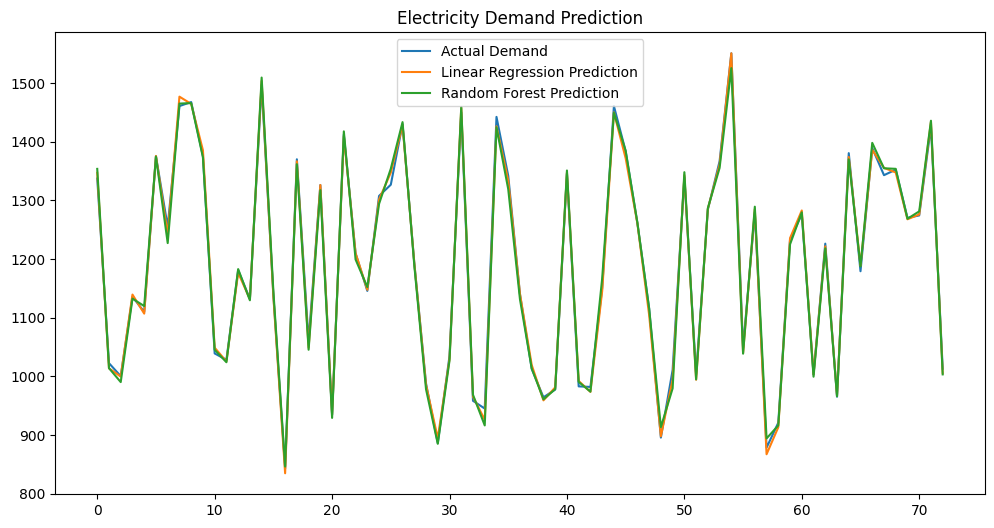

In [30]:
# Plot Linear Regression vs Random Forest predictions
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Demand')
plt.plot(y_pred_lr, label='Linear Regression Prediction')
plt.plot(y_pred_rf, label='Random Forest Prediction')
plt.legend()
plt.title('Electricity Demand Prediction')
plt.show()